In [1]:
from scipy.fft import fft, ifft
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import pywt
import scaleogram as scg

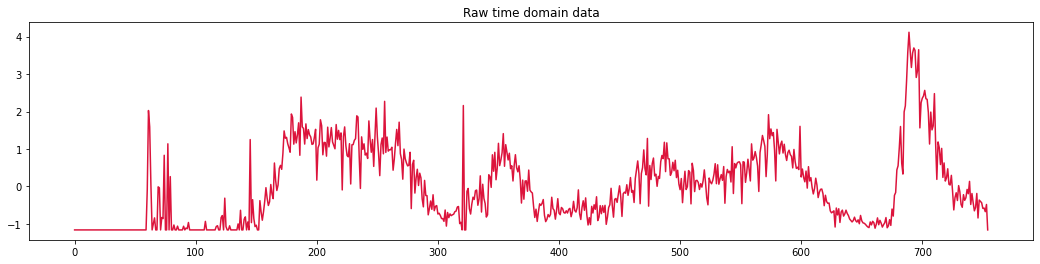

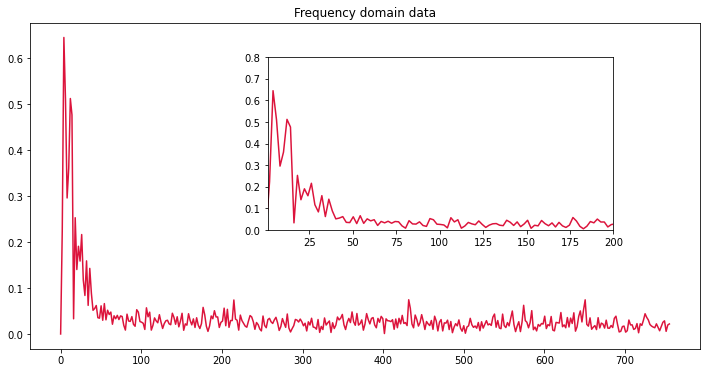

In [3]:
data = pd.read_pickle("ratesClusters_filled_days.pkl")

data = data[['AllDates', 'cluster', 'Taken Date', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'Total']]
data['posRate'] = data['POSITIVE'] / data['Total'] # this will give NaN when total = 0
data.fillna(0, inplace=True)
data.head()

data = data[data['cluster']=="0"]

y = data['posRate'].array
y = StandardScaler().fit_transform(y.reshape(-1,1))
y = y.reshape(1,-1)[0]

plt.figure(figsize=(18,4))
plt.plot(y, color='crimson')
plt.title('Raw time domain data')

N = len(y) # number of sample points
T = (N*2)**-1   # samples spacing, inverse of N*2

yf = fft(y)
x = np.linspace(0.0, N*T, N)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

plt.figure(figsize=(12,6))
ax1 = plt.axes()  # standard axes
ax1.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='crimson')

ax1.set_title('Frequency domain data')
ax2 = plt.axes([0.4, 0.4, 0.4, 0.4])
ax2.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='crimson')
ax2.set_xlim(1,200)
ax2.set_ylim(0,0.8)

plt.show()

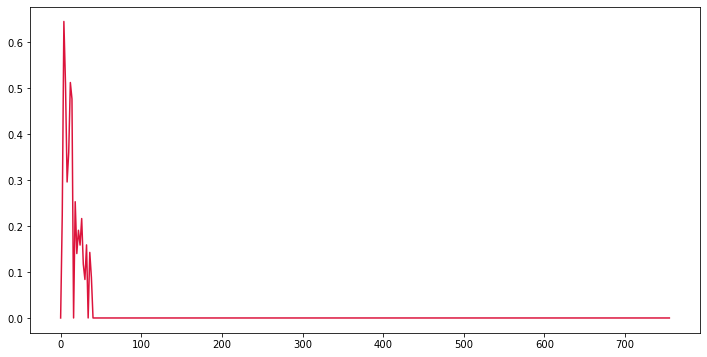

In [4]:
plt.figure(figsize=(12,6))
noisyY = yf.copy()
noisyY[np.abs(yf) < 30] = 0
plt.plot(xf, 2.0/N * np.abs(noisyY[:N//2]), color='crimson')
plt.show()

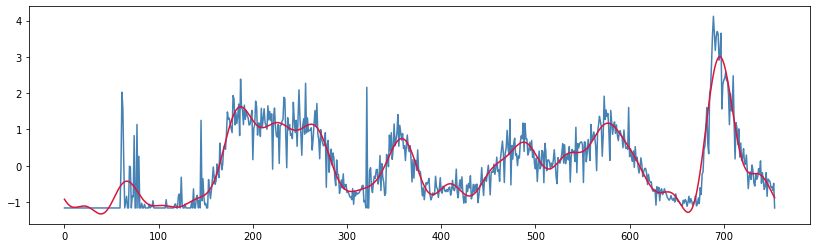

In [5]:
plt.figure(figsize=(14,4))
filtered_sig = ifft(noisyY)
plt.plot(y, color='steelblue')
plt.plot(np.real(filtered_sig), color='crimson')
plt.show()

In [6]:
fftDf = pd.DataFrame()
fftDf['iFFT_filtered_signal'] = np.real(filtered_sig)
fftDf['cluster'] = 0

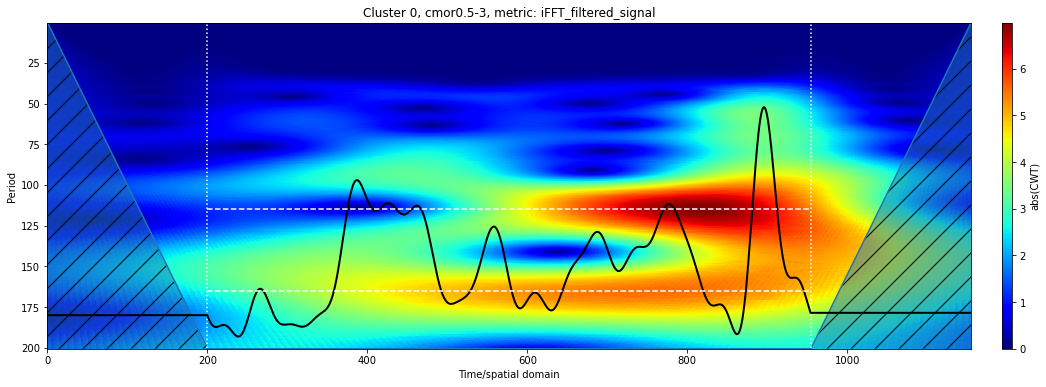

In [7]:
def graphScales(data, metric, s, wavelet, coi, padLen, padMode, cluster, spectrum, yaxis):
    '''
    
    https://pywavelets.readthedocs.io/en/latest/ref/index.html
    
    https://github.com/alsauve/scaleogram
    
    data: a dataframe
    metric: the column in the dataframe you want to use
    s: the scales used, input as an array
    wavelet: refer to pyWavelets documantation
    coi: Cone of inference, True of False
    padLen:  How many data point to pad with, front and back
    padMode: which mode to use for pading, refer to pyWavelets documentation
    cluster: the cluster of interest    
    '''
    
    data = data[data['cluster']==cluster]
    
    # we can get x data from y len
    y = data[f'{metric}'].array.reshape(-1,1)
    
    # Standardize features by removing the mean and scaling to unit variance.
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    y = StandardScaler().fit_transform(y)
    y = y.reshape(1,-1)[0]
    
    #smooth
    #y = smooth(y)
    
    
    #pad the data
    yPadded = pywt.pad(y, padLen, padMode)
    
    # make an array of scales
    scales = np.arange(s[0], s[1])
    
    # Plot the data
    #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,8))
    fig,  ax2 = plt.subplots(1,1, figsize=(18,6))
    #fig.subplots_adjust(hspace=0.3)    
    
    # Plot the signal
    #ax1.plot(np.arange(0, len(yPadded)), yPadded)   
    # add pading lines as indication of what is important
    #ax1.vlines(x=[padLen, len(yPadded) - padLen, 850], 
    #           ymin=min(yPadded), ymax=max(yPadded), color='black', ls="dotted")
    
    
    
    # Plot the scaleogram
    ax2 = scg.cws(np.arange(0, len(yPadded)), yPadded, scales=scales, wavelet=wavelet, 
                  coi=coi, ax=ax2, 
                  title = f'Cluster {cluster}, {wavelet}, metric: {metric}',
                 cbar='vertical', yaxis=yaxis, spectrum=spectrum, cmap='jet')
     
    ax2.vlines(x= [padLen, (len(yPadded) - padLen)], 
               ymin=200, ymax=0, color='white', ls="dotted")
    ax2.plot(np.arange(0, len(yPadded)), 150-yPadded*30, color='black', lw=2)
    
    ax2.hlines(y=[165, 115], xmin=padLen, xmax=(len(yPadded) - padLen), color='white', ls='dashed')

graphScales(data=fftDf,metric='iFFT_filtered_signal', s=[1,600], wavelet='cmor0.5-3', coi=True, padLen=200, padMode='constant', cluster=0,
           spectrum='amp', yaxis='period')